# Optimized gauge transformation

## The goal of this notebook is to perform the gauge transformation in an optimized way inside the temporal loop so we can later move it to the GPU

### Set parametres and eviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 128   
tau_sim = 1     
DTS = 8
t_steps = int(tau_sim/(L/N))   

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.gauge_transformation as gt
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


### We define the simulation routine

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, N, Dg)))
    v_LC = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            

            # Copy the necessary fields
            if t%DTS == 0 or t == 1:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
                
                ae_act = s.aeta1.copy().reshape(N, N, Dg)
                ae_prev = s.aeta0.copy().reshape(N, N, Dg)
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            v_prev = v_LC[xplus, y, z]
                            
                            if t == 1: # We initialize the gauge operator
                                v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus,y], ae_act[2*xplus,y], v_prev, z, N, t)
                            
                            elif xplus > (t//DTS) and t!=0: # We construct the gauge operator
                                v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], ae_act[2*xplus-t//DTS,y], v_prev, z, N, t//DTS)
                                
                            elif xplus == (t//DTS) and t!=0: # We transform the plus links
                                uplus_LC[xplus-1, y, z] = gt.act_on_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], v_LC[xplus, y, z], v_LC[xplus-1, y, z], z, N, t//DTS)
                                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC

### We perform the simulation

In [4]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
uplus_LC = simulate()

### We make some plots to check the shape of the transformed fields

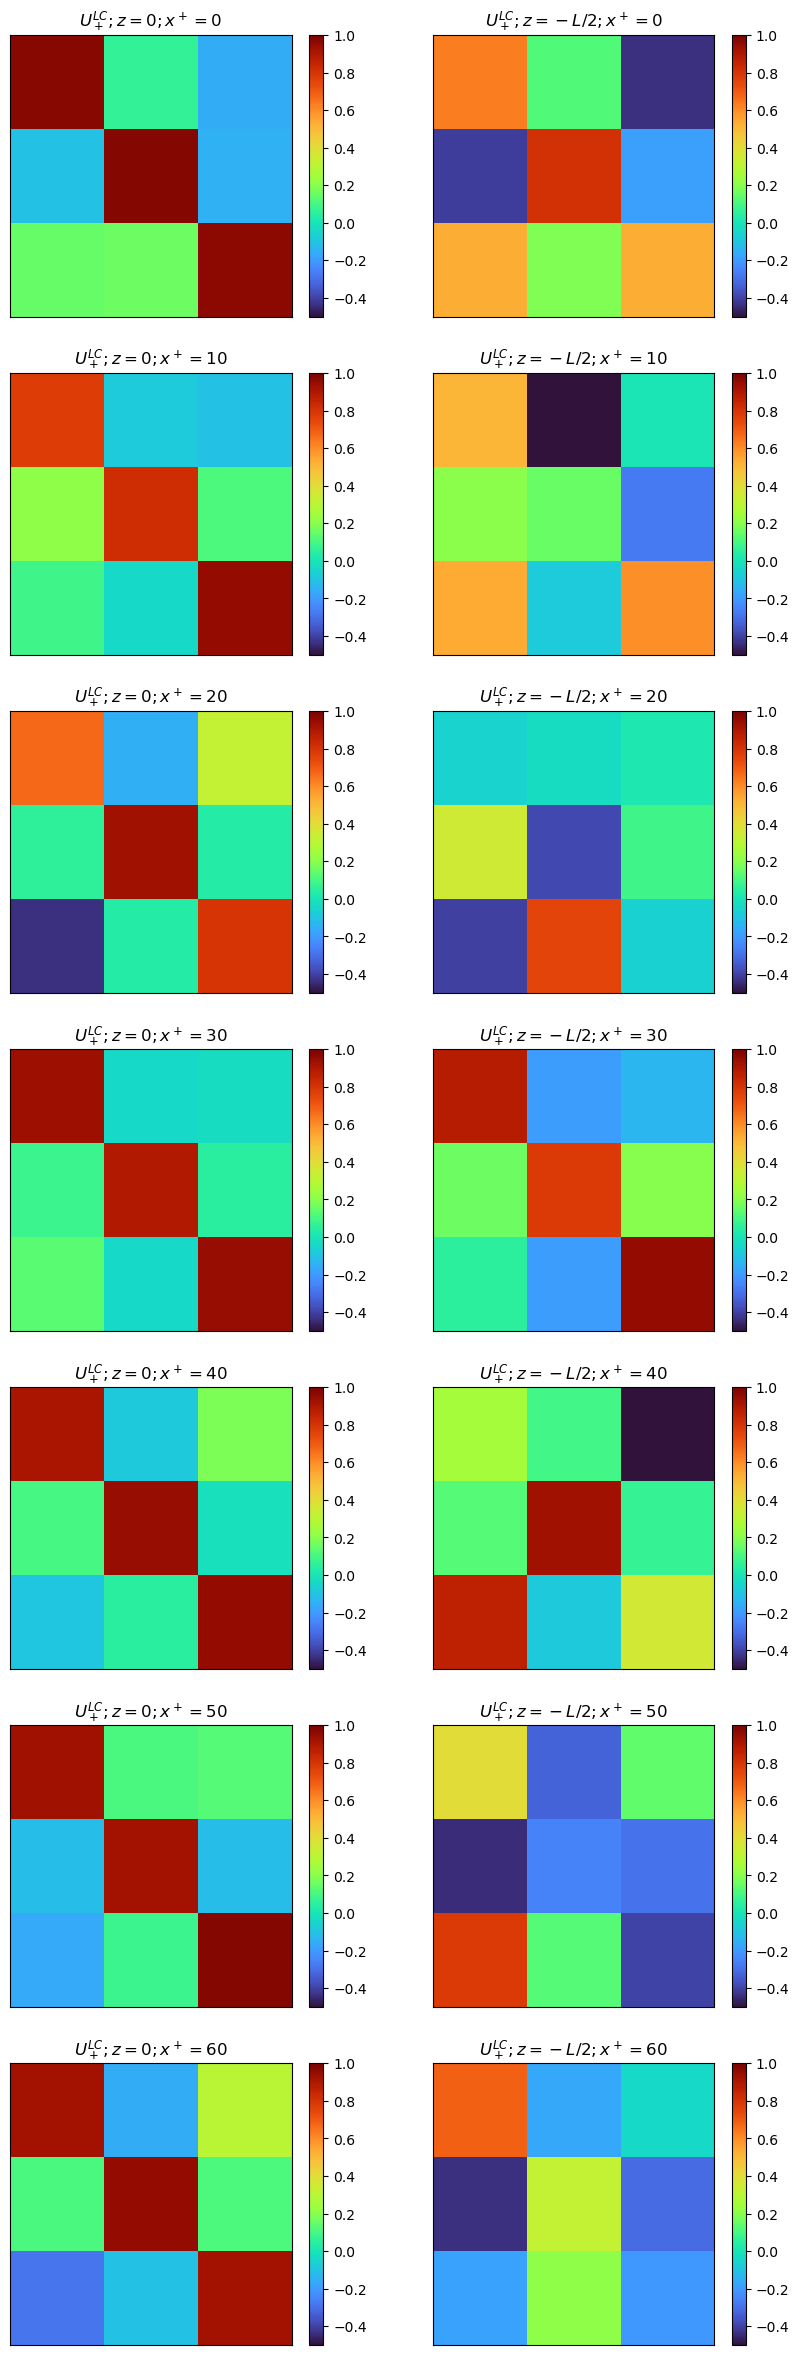

In [7]:
import matplotlib.pyplot as plt 

# We plot the matrix elements of the transformed fields at central and extreme values of z

y = N//2

uplus_LC_plot = uplus_LC.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_plot[tau, y, N//2, :, :].real, cmap='turbo', vmin=-0.5, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_LC_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.5, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

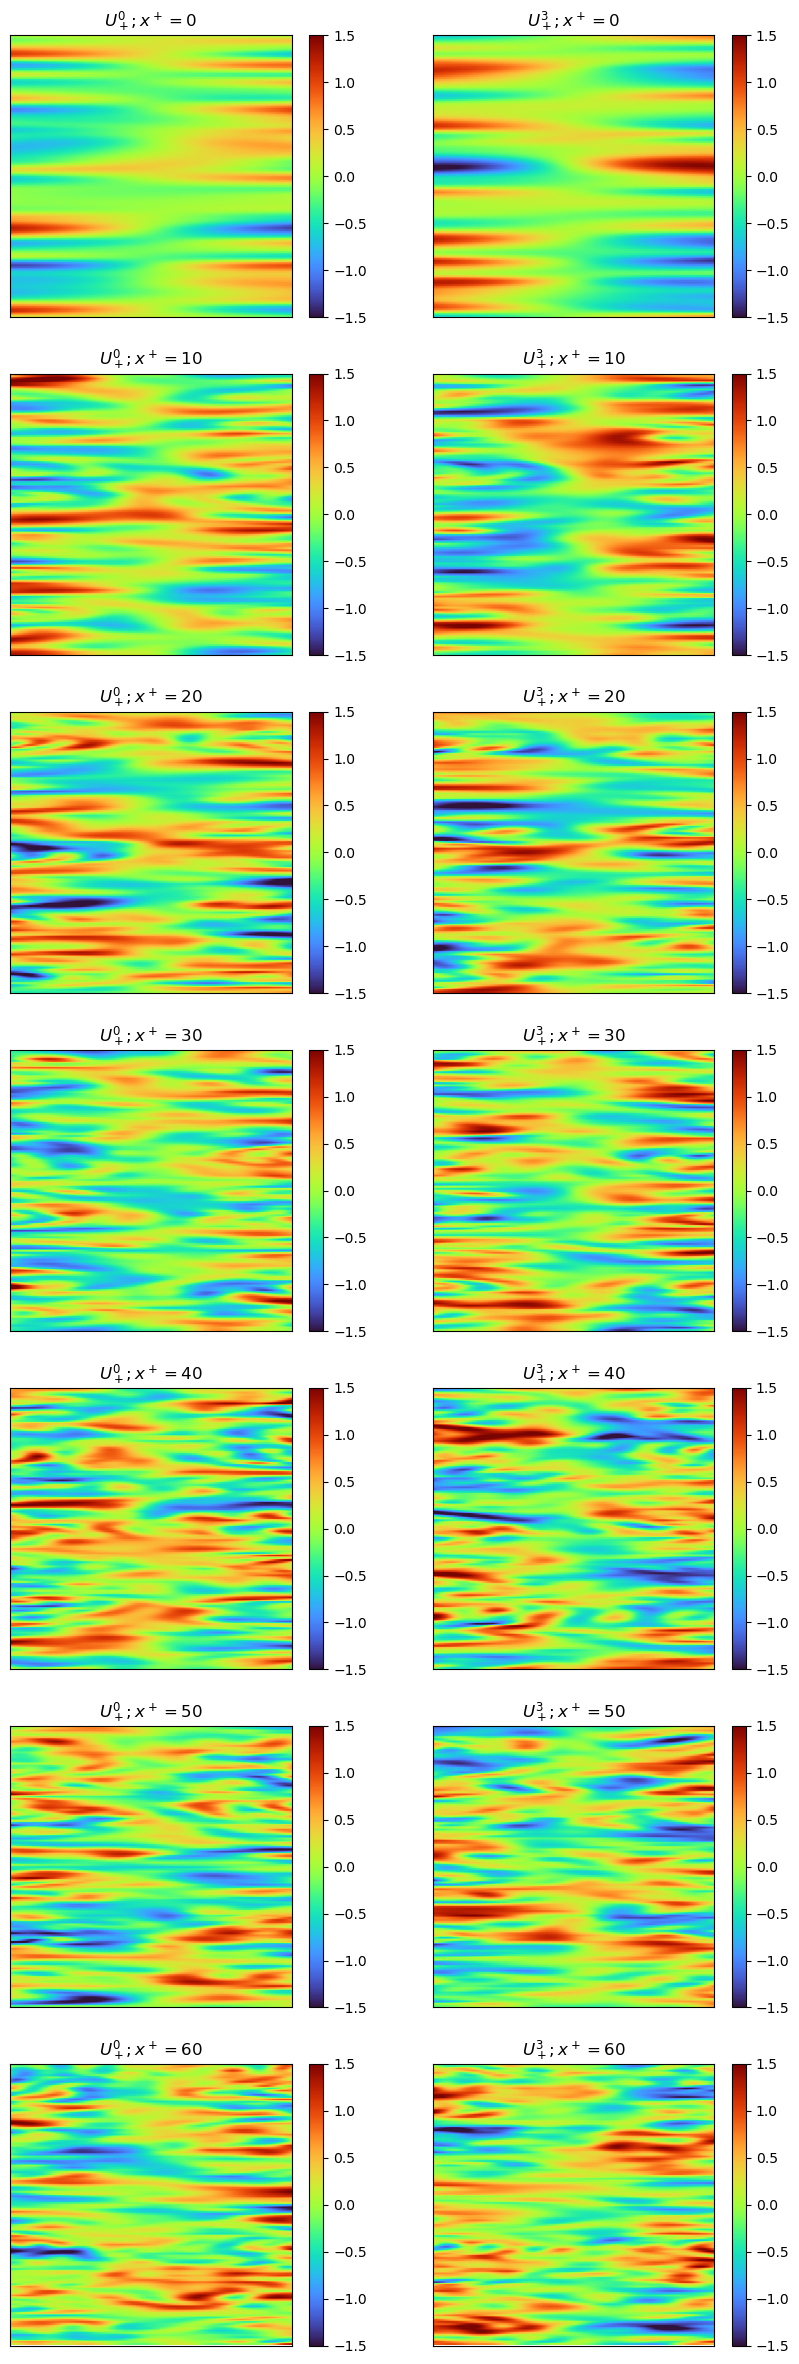

In [8]:
# We a color component of the transformed field in the transverse plane
u_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, uplus_LC)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(u_comp[tau, :, :, 0].real, cmap='turbo', vmin=-1.5, vmax=1.5) 
    axs[t,0].set_title(r'$U_+^{0}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(u_comp[tau, :, :, 3].real, cmap='turbo', vmin=-1.5, vmax=1.5)
    axs[t,1].set_title(r'$U_+^{3}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

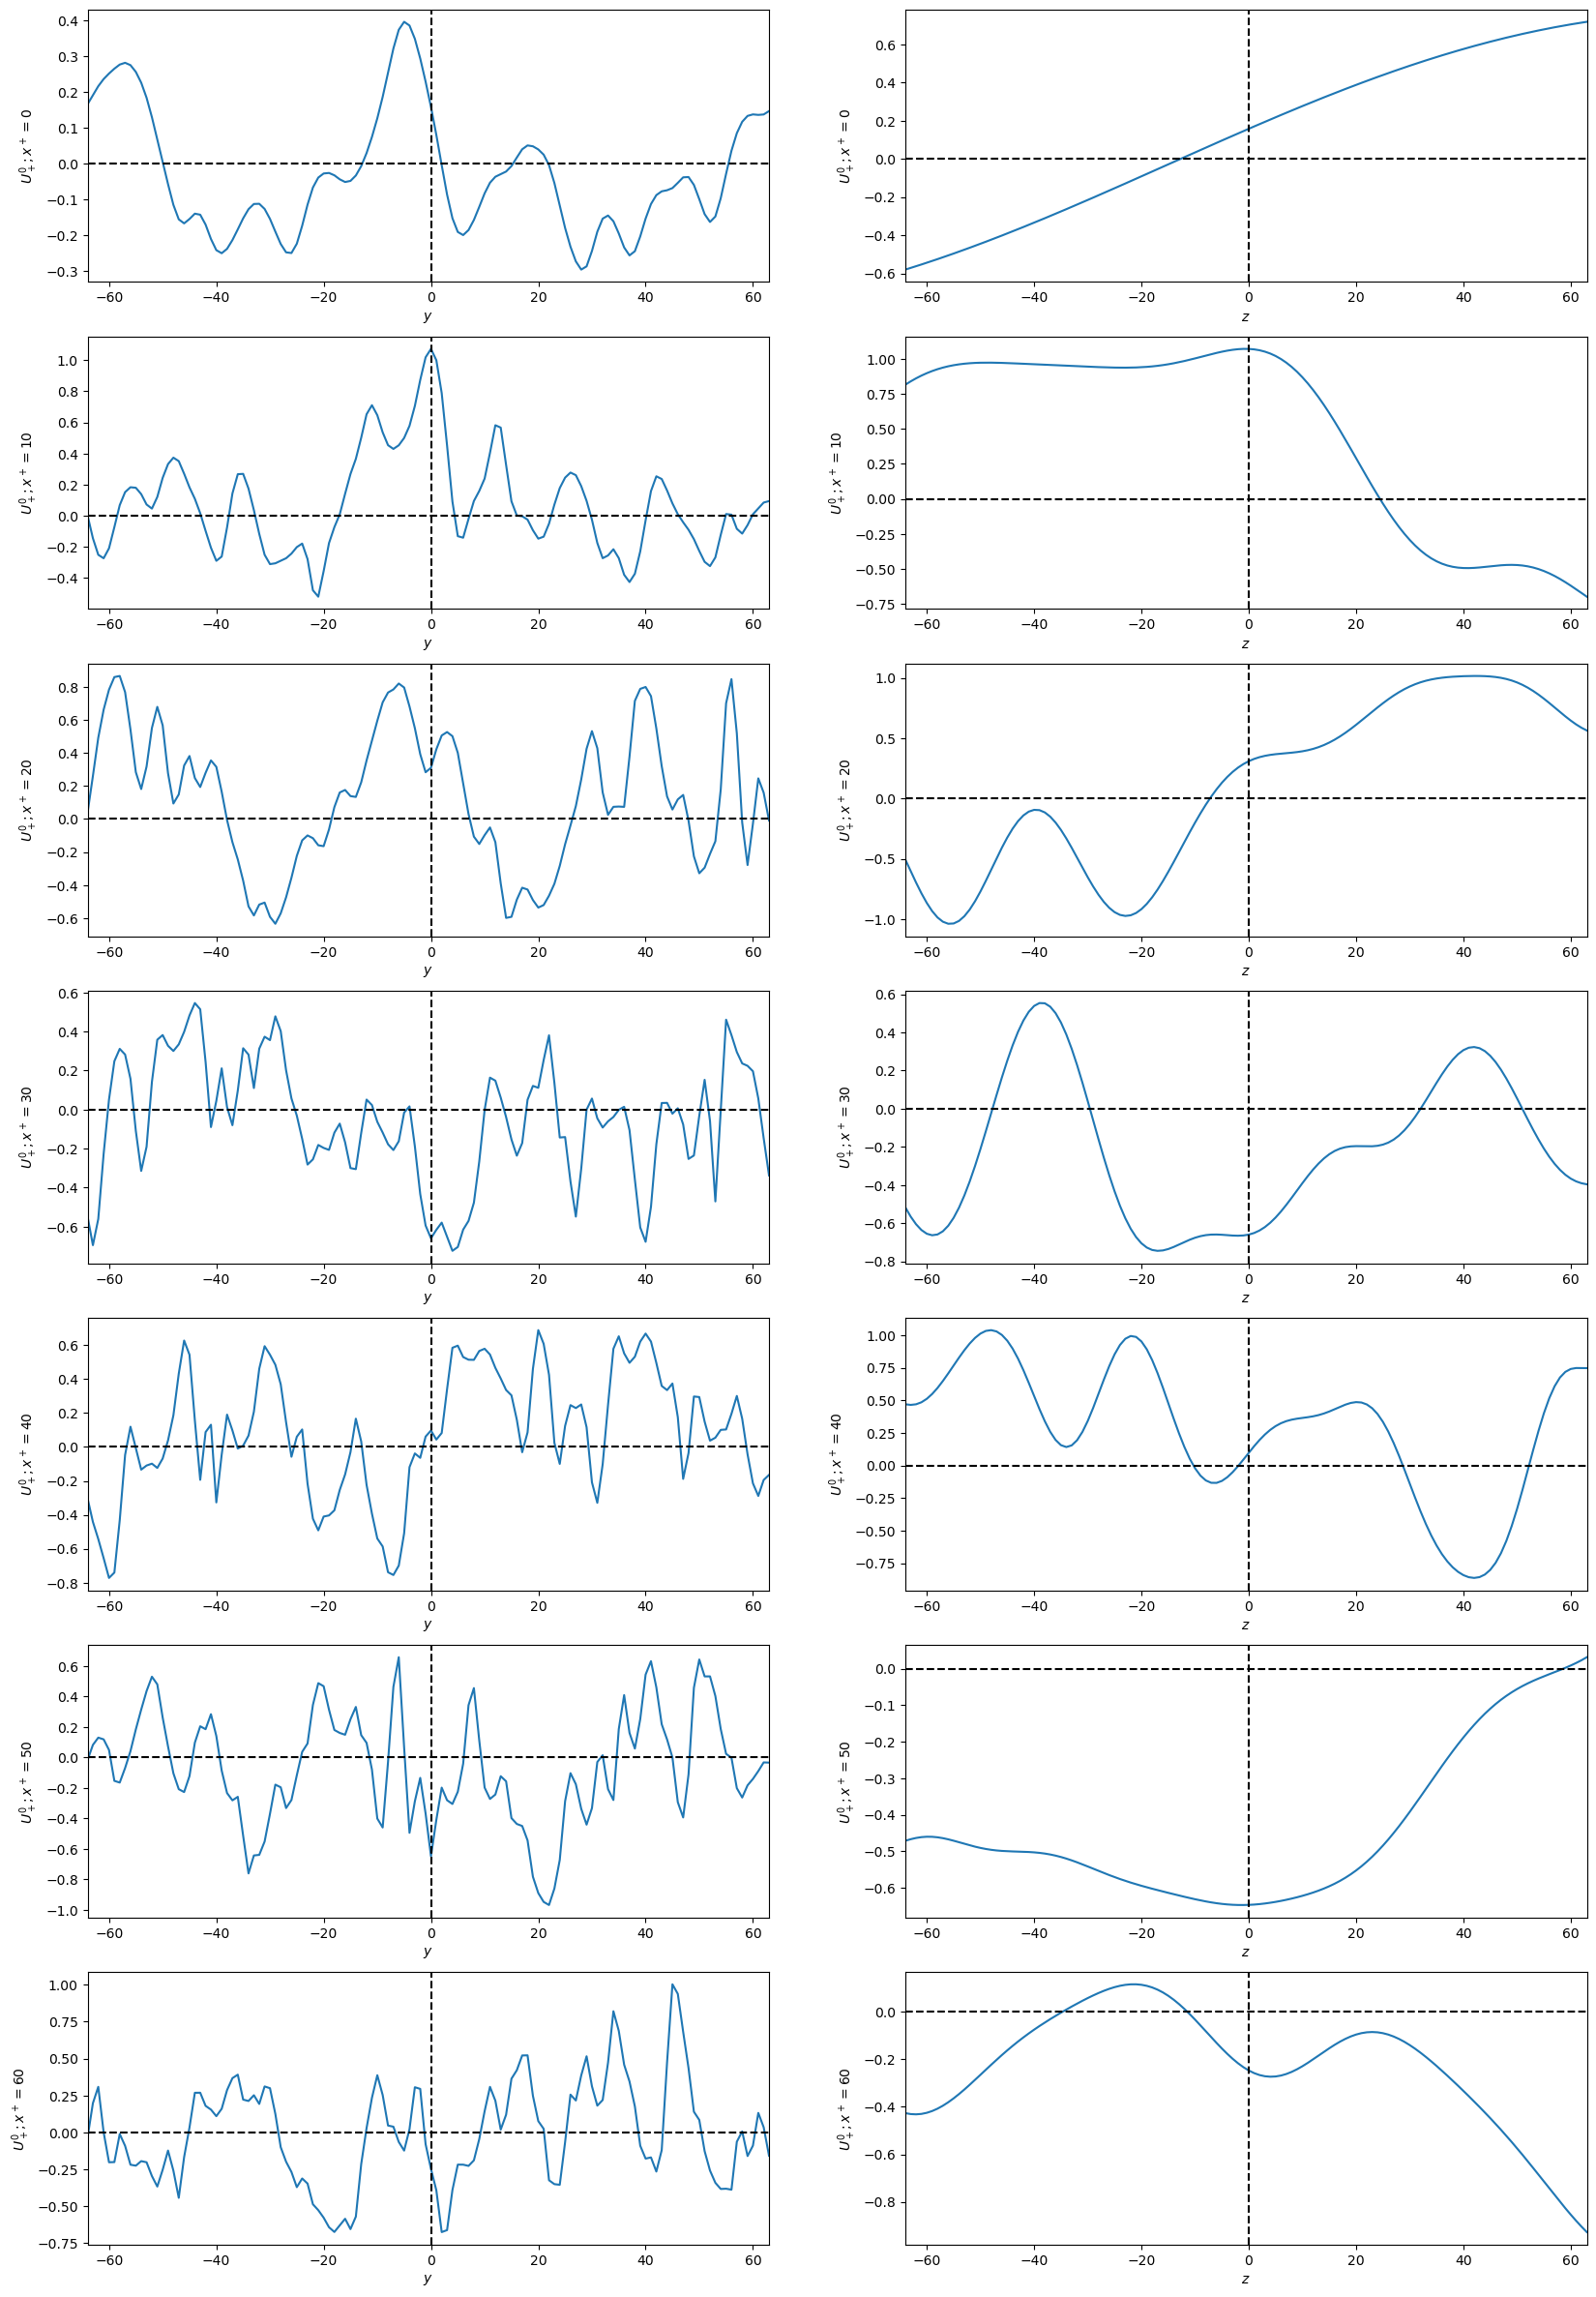

In [9]:
# We plot the links for a single color component as a function of y and as a function of z

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(20,30))
aux = np.linspace(0,127, 128)

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].plot(aux-N//2, u_comp[tau, :, N//2, 0].real) 
    axs[t,0].hlines(0, -64, 63, colors="black", linestyle='dashed')
    ymin, ymax = axs[t,0].get_ylim()
    axs[t,0].vlines(0, ymin, ymax, colors='black', linestyle='dashed')
    axs[t,0].set_xlabel(r'$y$')
    axs[t,0].set_ylabel(r'$U_+^{0}; x^+ = %i $' %tau)
    axs[t,0].set_xlim(-64, 63)
    axs[t,0].set_ylim(ymin, ymax)
    
    plot2 = axs[t,1].plot(aux-N//2, u_comp[tau, N//2, :, 0].real)
    axs[t,1].hlines(0, -64, 63, colors="black", linestyle='dashed')
    ymin, ymax = axs[t,1].get_ylim()
    axs[t,1].vlines(0, ymin, ymax, colors='black', linestyle='dashed')
    axs[t,1].set_xlabel(r'$z$')
    axs[t,1].set_ylabel(r'$U_+^{0}; x^+ = %i $' %tau)
    axs[t,1].set_xlim(-64, 63)
    axs[t,1].set_ylim(ymin, ymax)

By last we want to plot $|A_+|^2$ as a function of $y$ and $z$

In [10]:
# We extract the fields from the links

A_plus = su.GROUP_TYPE([[[su.mul_s(su.add(uplus_LC[xplus, y, z], su.mul_s(su.dagger(uplus_LC[xplus, y, z]), -1)), 0.5) for z in range(N)] for y in range(N)] for xplus in range(t_steps-1)])

print(np.shape(A_plus))

(63, 128, 128, 9)


In [11]:
# We get the color components of the field

A_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, A_plus)

print(np.shape(A_comp))

(63, 128, 128, 8)


In [26]:
# We Fourier transform the color components

A_trans = np.fft.fft2(A_comp, axes=(1, 2))
freq = np.fft.fftfreq(128, d=1)

print(np.shape(A_trans))

(63, 128, 128, 8)


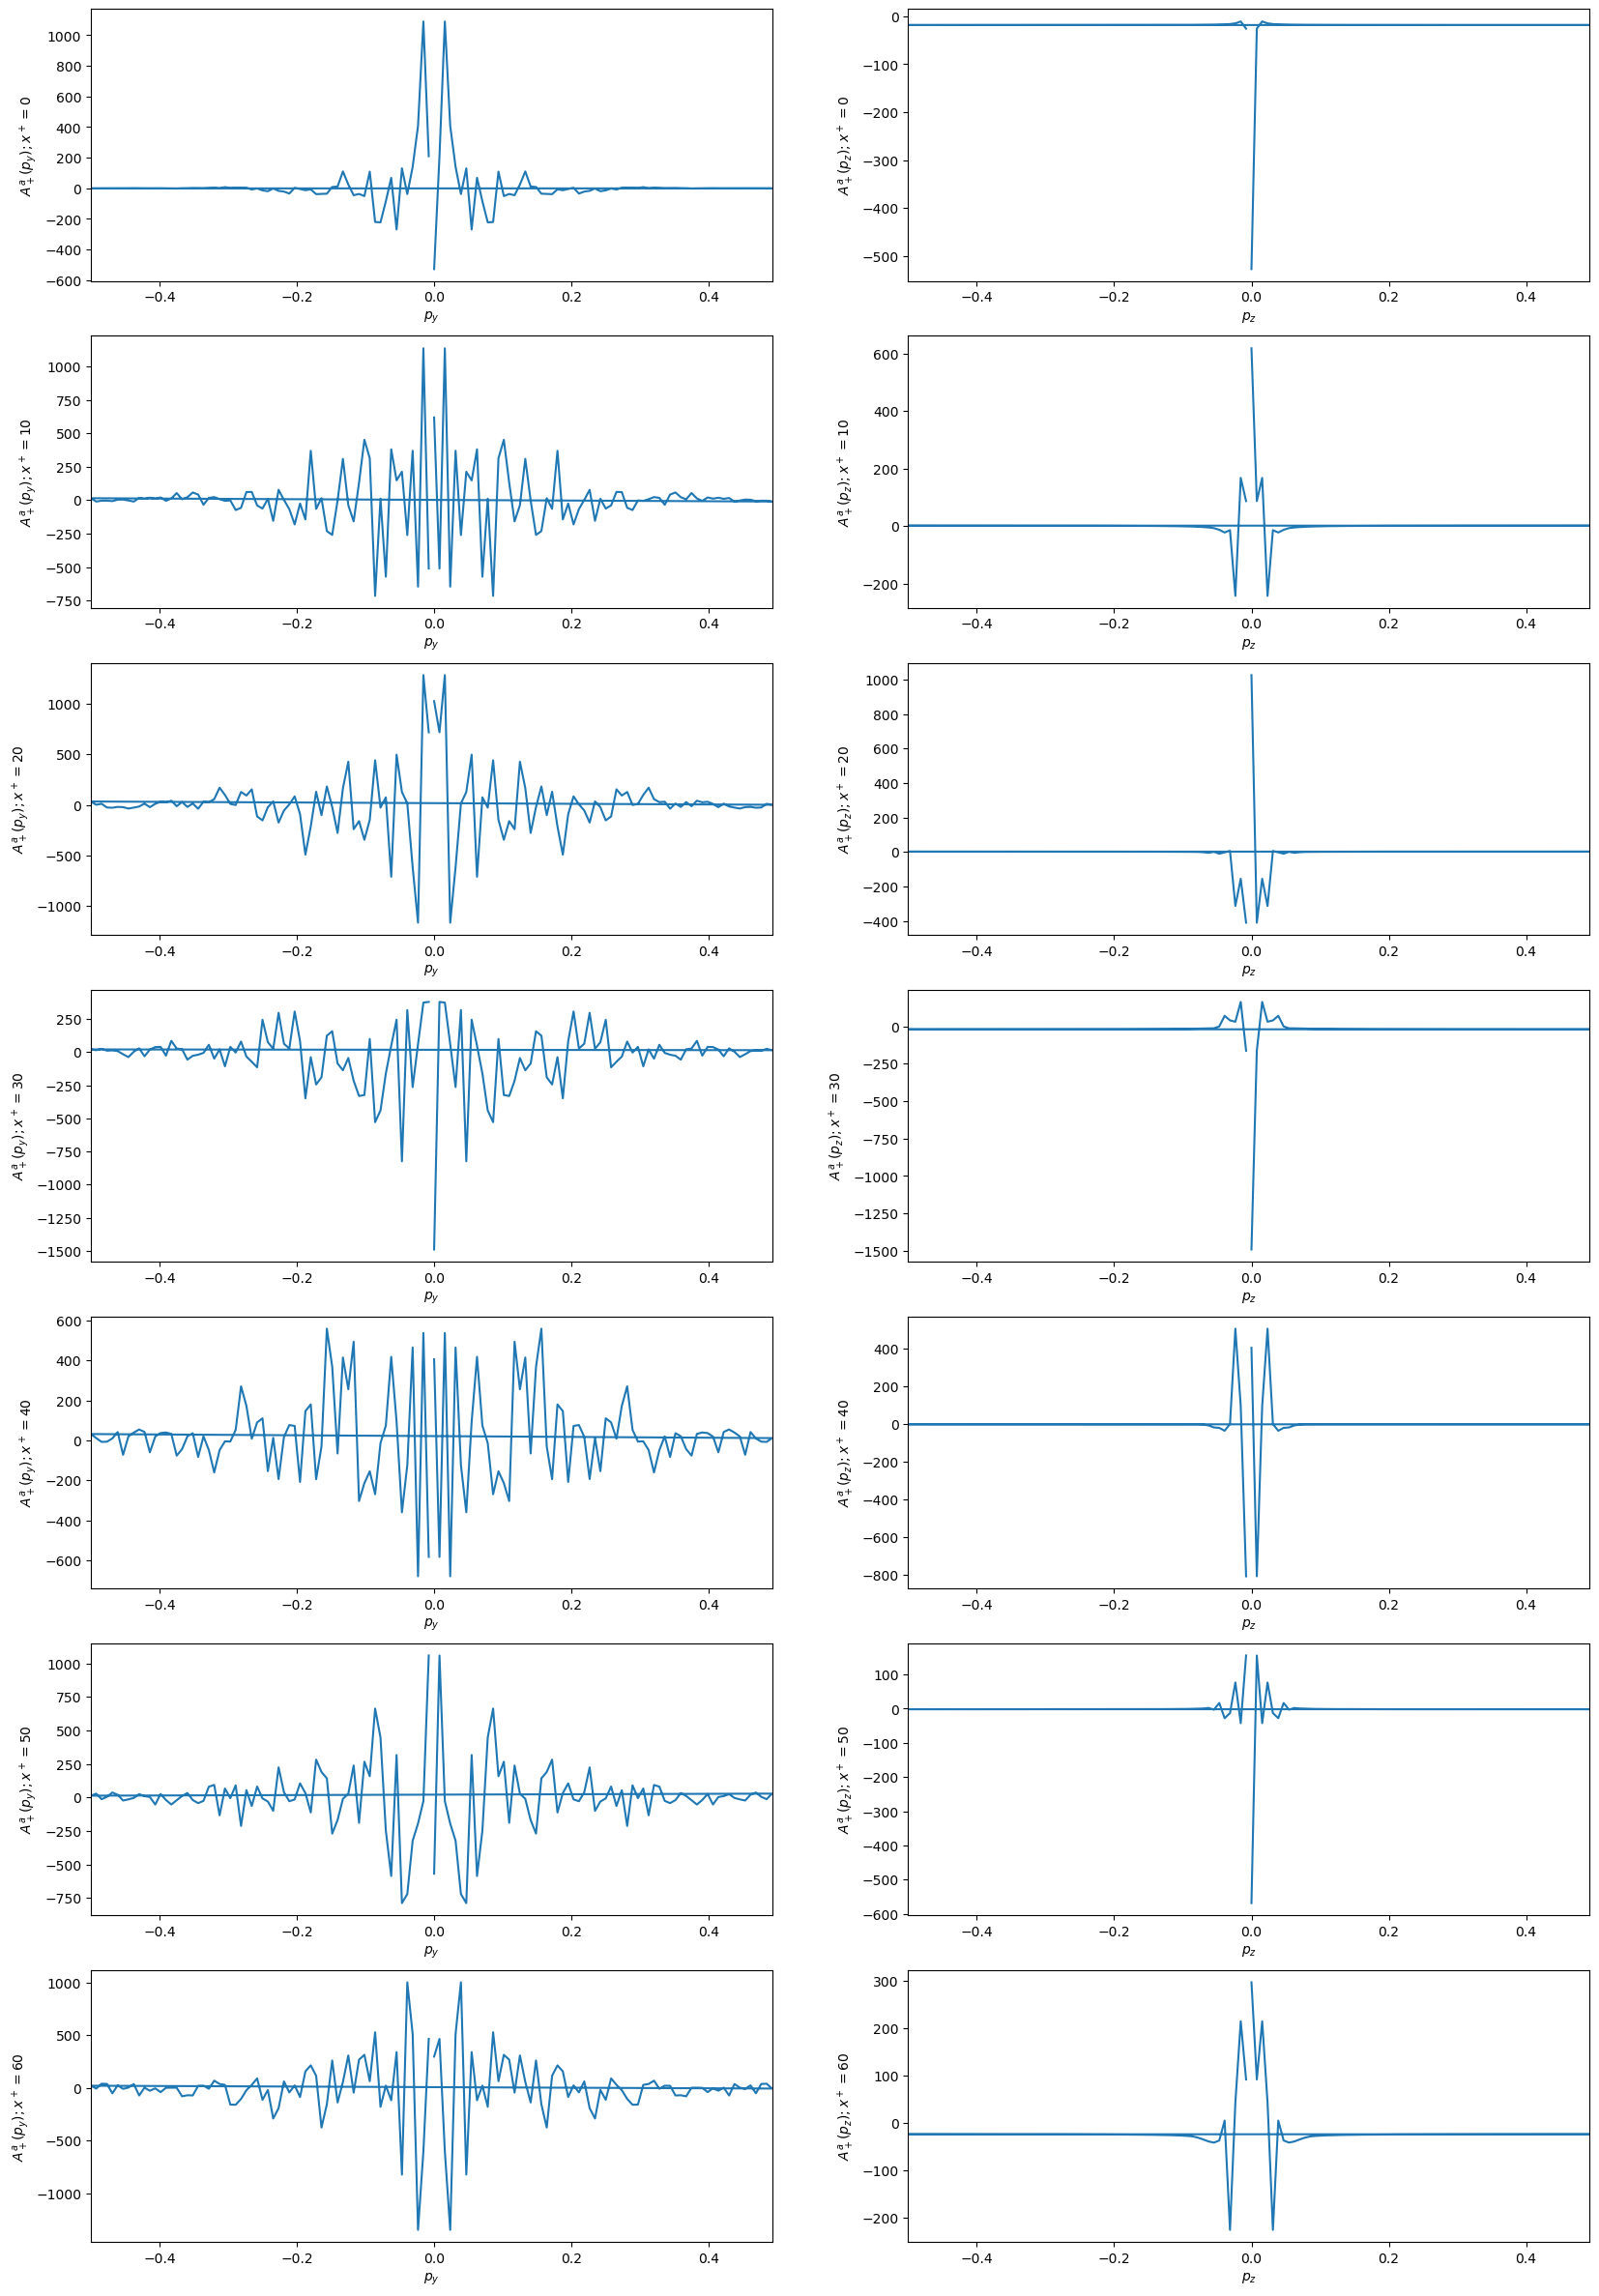

In [41]:
# We plot a color component the field as a function of py and pz

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(20,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].plot(freq, A_trans[tau, :, 0, 0].real) 
    axs[t,0].set_xlabel(r'$p_y$')
    axs[t,0].set_ylabel(r'$A^a_+(p_y); x^+ = %i $' %tau)
    axs[t,0].set_xlim(min(freq), max(freq))
    
    plot2 = axs[t,1].plot(freq, A_trans[tau, 0, :, 0].real)
    axs[t,1].set_xlabel(r'$p_z$')
    axs[t,1].set_ylabel(r'$A^a_+(p_z); x^+ = %i $' %tau)
    axs[t,1].set_xlim(min(freq), max(freq))

In [36]:
# We sum the squared modulus of every component

A = np.zeros((t_steps-1, N, N))

for xplus in range(t_steps-1):
    for y in range(N):
        for z in range(N):
            A[xplus, y, z] = np.sum([np.abs(A_trans[xplus, y, z, c])**2 for c in range(Nc)])

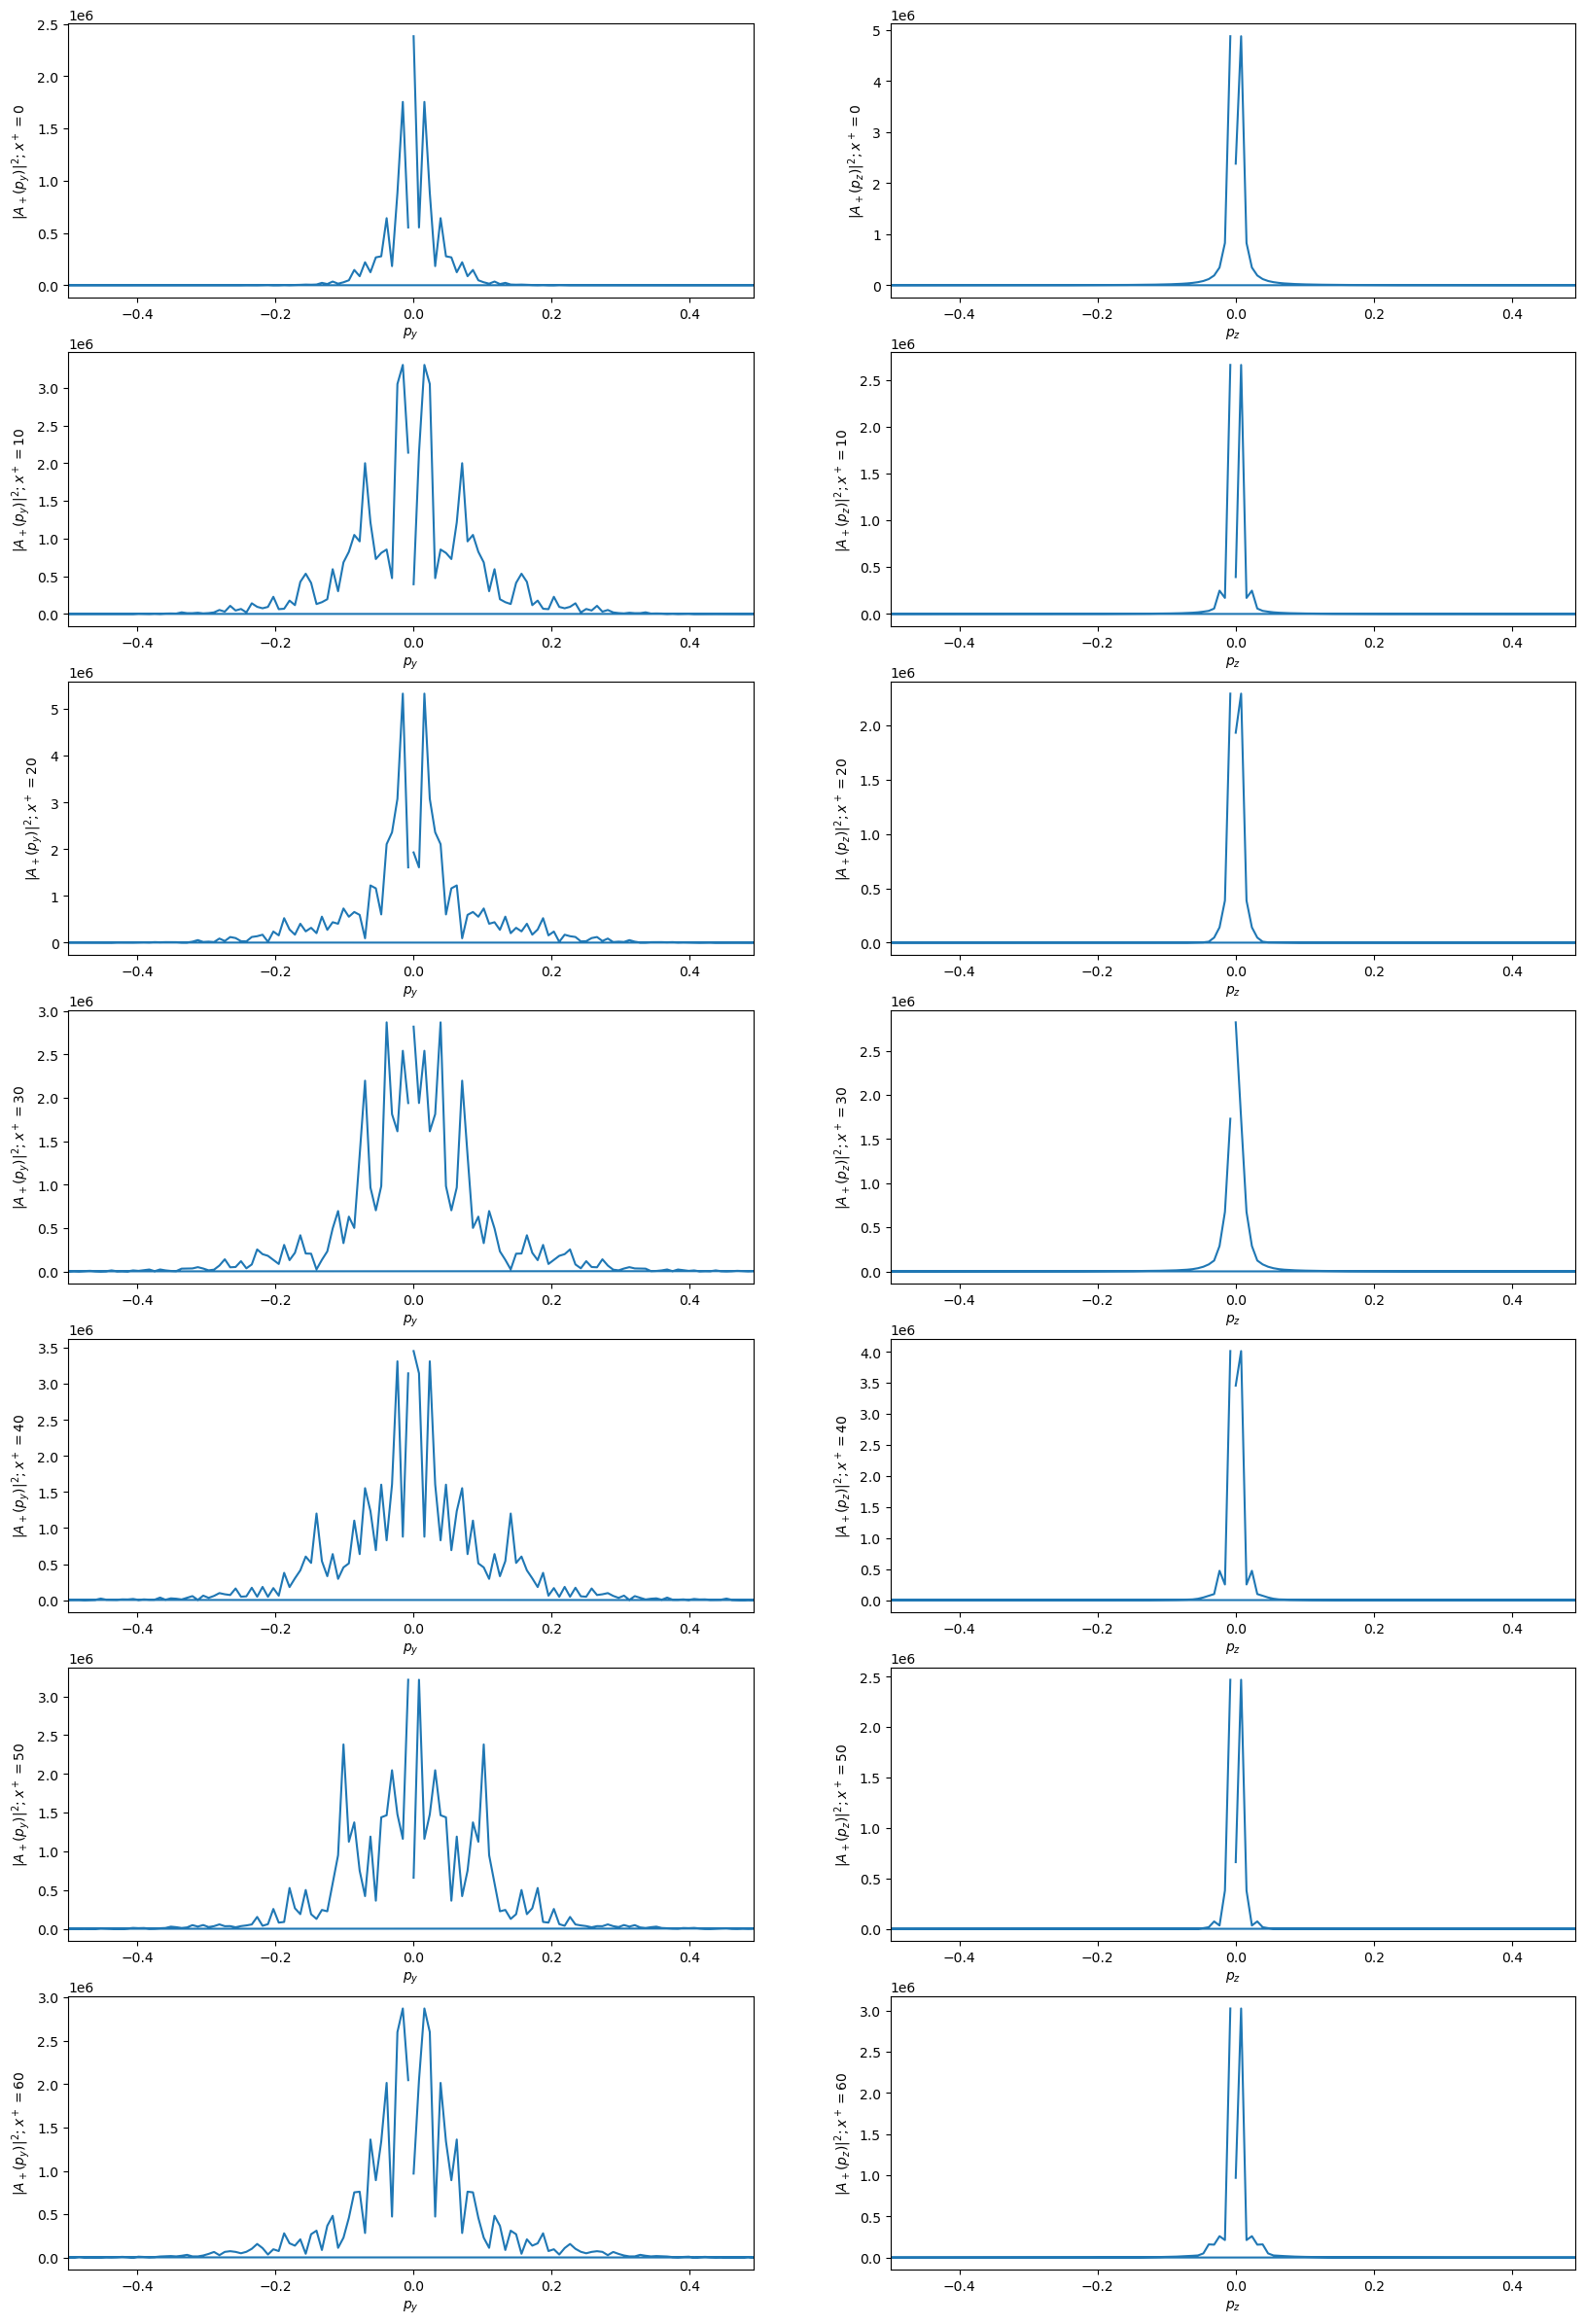

In [42]:
# We plot this objetc as a function of py and pz

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(20,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].plot(freq, A[tau, :, 0].real) 
    axs[t,0].set_xlabel(r'$p_y$')
    axs[t,0].set_ylabel(r'$|A_+(p_y)|^2; x^+ = %i $' %tau)
    axs[t,0].set_xlim(min(freq), max(freq))
    
    plot2 = axs[t,1].plot(freq, A[tau, 0, :].real)
    axs[t,1].set_xlabel(r'$p_z$')
    axs[t,1].set_ylabel(r'$|A_+(p_z)|^2; x^+ = %i $' %tau)
    axs[t,1].set_xlim(min(freq), max(freq))

- - -
Write the outputs to files. First, the numerical Glasma parameters in `glasma_parameters.txt`.

In [ ]:
# Save relevant parameters to text file
param_names = ["L [fm]", "N", "a [fm]", "tau_sim [fm/c]", "tau_steps"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L, N, L/N, tau_sim, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

In [ ]:
# Save relevant parameters to text file
param_names = ["L_perp [GeV^-1]", "N_perp", "time_tot [GeV^-1]", "time_step"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L/2/hbarc, round(N/2), tau_sim*np.sqrt(2)/hbarc, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters_qjetlfh_input.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

Second, the transformed gauge link $U_+ (x^+, y, z)$ as a `numpy` array in `uplus_glasma.npy`.

In [ ]:
np.save('uplus_glasma_v2.npy', uplus_LC)

In [ ]:
# I use this values to test that reading the numpy array in C++ is correct
uplus_LC[10, 12, 10, :]

array([ 0.53989075+0.56241178j, -0.55276919+0.04226602j,
       -0.04508108+0.28781673j,  0.40830094-0.41220644j,
        0.03462986-0.78023119j, -0.10954871+0.20350754j,
       -0.17104874+0.16226361j,  0.27383264-0.0878382j ,
        0.66578141+0.64687564j])

- - -
Read the input file `uplus_glasma.npy` sent to Meijian.

In [ ]:
import numpy as np

uplus = np.load('uplus_glasma.npy')
nplus, N, Dg = uplus.shape[0], uplus.shape[1], uplus.shape[3]

Output a time slice, let's choose $x^+_\mathrm{lattice}=10$, the (y,z) dependence, in a `*.txt` file, for Meijian.

In [ ]:
# Output each color components in a different file, as a yz array

folder_path = "results/uplus_glasma_xplus_10_color/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for c in range(Dg):
    output_file = open(folder_path + "c_" + str(c) + ".txt", "a")
    for y in range(N):
        for z in range(N):
            output_file.write(str(uplus[10, y, z, c]) + " ")
            if z==(N-1):
                output_file.write(str(uplus[10, y, z, c]) + "\n")
output_file.close()

In [ ]:
folder_path = "results/uplus_glasma_xplus_10_coord/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Output all color components for each yz pair in a different file
for y in range(N):
    for z in range(N):
        output_file = open(folder_path + "y_" + str(y) + "_z_" + str(z) + ".txt", "a")
        for c in range(Dg):
            output_file.write(str(uplus[10, y, z, c]) + "\n")
output_file.close()

- - -
Output all $x^+$ time slices to `*.txt` files for Meijian, with the real and imaginary parts of the color components in separate files

In [ ]:
import os

# Output each color components in a different file, as a yz array

folder_path = "results/uplus_glasma_txt/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for xplus in range(nplus):
    folder_xplus = folder_path + "xplus_" + str(xplus) + "/"

    if not os.path.exists(folder_xplus):
        os.makedirs(folder_xplus)

    for c in range(Dg):
        output_file_real = open(folder_xplus + "c_" + str(c) + "_re.txt", "a")
        output_file_imag = open(folder_xplus + "c_" + str(c) + "_im.txt", "a")
        for y in range(N):
            for z in range(N):
                output_file_real.write(str(uplus[xplus, y, z, c].real) + " ")
                output_file_imag.write(str(uplus[xplus, y, z, c].imag) + " ")
                if z==(N-1):
                    output_file_real.write(str(uplus[xplus, y, z, c].real) + "\n")
                    output_file_imag.write(str(uplus[xplus, y, z, c].imag) + "\n")
    output_file_real.close()
    output_file_imag.close()